In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from keras import backend as k
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
import os
import sklearn

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
tf.data.experimental.enable_debug_mode()

In [12]:
def multi_unet_model(IMG_SIZE,IMG_CHANNELS,N_CLASSES):
    IMG_HEIGHT,IMG_WIDTH = IMG_SIZE

  ###INPUT###

    inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
#     s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  ###ENCODING LAYER###

    c1 = tf.keras.layers.Conv2D(64,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c1)
    p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(64*2,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(64*2,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c2)
    p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(64*4,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(p2)
    c3 = tf.keras.layers.Dropout(0.1)(c3)
    c3 = tf.keras.layers.Conv2D(64*4,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c3)
    p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(64*8,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(p3)
    c4 = tf.keras.layers.Dropout(0.1)(c4)
    c4 = tf.keras.layers.Conv2D(64*8,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c4)
    p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

    c5 = tf.keras.layers.Conv2D(64*16,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(p4)
    c5 = tf.keras.layers.Dropout(0.1)(c5)
    c5 = tf.keras.layers.Conv2D(64*16,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c5)

  ###DECODING LAYER###

    c6 = tf.keras.layers.Conv2DTranspose(64*8,(2,2),strides = (2,2),padding = 'same')(c5)
    c6 = tf.keras.layers.concatenate([c6,c4])
    c6 = tf.keras.layers.Conv2D(64*8,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(64*8,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c6)

    c7 = tf.keras.layers.Conv2DTranspose(64*4,(2,2),strides = (2,2),padding = 'same')(c6)
    c7 = tf.keras.layers.concatenate([c7,c3])
    c7 = tf.keras.layers.Conv2D(64*4,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64*4,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c7)

    c8 = tf.keras.layers.Conv2DTranspose(64*2,(2,2),strides = (2,2),padding = 'same')(c7)
    c8 = tf.keras.layers.concatenate([c8,c2])
    c8 = tf.keras.layers.Conv2D(64*2,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)
    c8 = tf.keras.layers.Conv2D(64*2,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c8)

    c9 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides = (2,2),padding = 'same')(c8)
    c9 = tf.keras.layers.concatenate([c9,c1])
    c9 = tf.keras.layers.Conv2D(64,(3,3), activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)
    c9 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu', kernel_initializer='he_normal',padding = 'same')(c9)

  ###OUTPUT###

    outputs = tf.keras.layers.Conv2D(N_CLASSES,(1,1),activation = 'sigmoid')(c9)

  ###MODEL###

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])

    return model

In [5]:
DATA_DIR = "/kaggle/input/lung-mask-image-dataset/ChestXray"
SET = ["train/","test/","val/"]

In [6]:
def make_patch(img):
    patch1 = img[:256,:256]
    patch2 = img[:256,256:]
    patch3 = img[256:,256:]
    patch4 = img[256:,:256]
    
    return [patch1,patch2,patch3,patch4]

In [7]:
XTRAIN = []
YTRAIN = []

TRAIN_PARENT_PATH = os.path.join(DATA_DIR,SET[0])
TRAIN_IMG_PATH = TRAIN_PARENT_PATH + 'image/'
TRAIN_MASK_PATH = TRAIN_PARENT_PATH + 'mask/'
count = 0

for img in os.listdir(TRAIN_IMG_PATH):
    if count<1000:
        IMG_PATH = os.path.join(TRAIN_IMG_PATH,img)
        img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        XTRAIN.append(img_array)
        count += 1
    else:
        print("XTRAIN DONE")
        break
        
count = 0

for mask in os.listdir(TRAIN_MASK_PATH):
    if count<1000:
        MASK_PATH = os.path.join(TRAIN_MASK_PATH,mask)
        img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        YTRAIN.append(img_array)
        count += 1
    else:
        print("YTRAIN DONE")
        break

XTRAIN DONE
YTRAIN DONE


In [8]:
def masking_ratio(img,shape):
    x,y = shape
    num_ones = np.sum(img)
    num_zeros = x*y - num_ones
    return num_ones/(num_ones + num_zeros)

In [9]:
XTRAIN = np.array(XTRAIN).reshape(-1,512,512,1)/511
YTRAIN = np.array(YTRAIN).reshape(-1,512,512,1).astype('float32')
print("DONE")

DONE


In [10]:
masking_ratio_values = np.zeros(len(YTRAIN))
for i in range(len(YTRAIN)):
    masking_ratio_values[i] = masking_ratio(YTRAIN[i],[512,512])

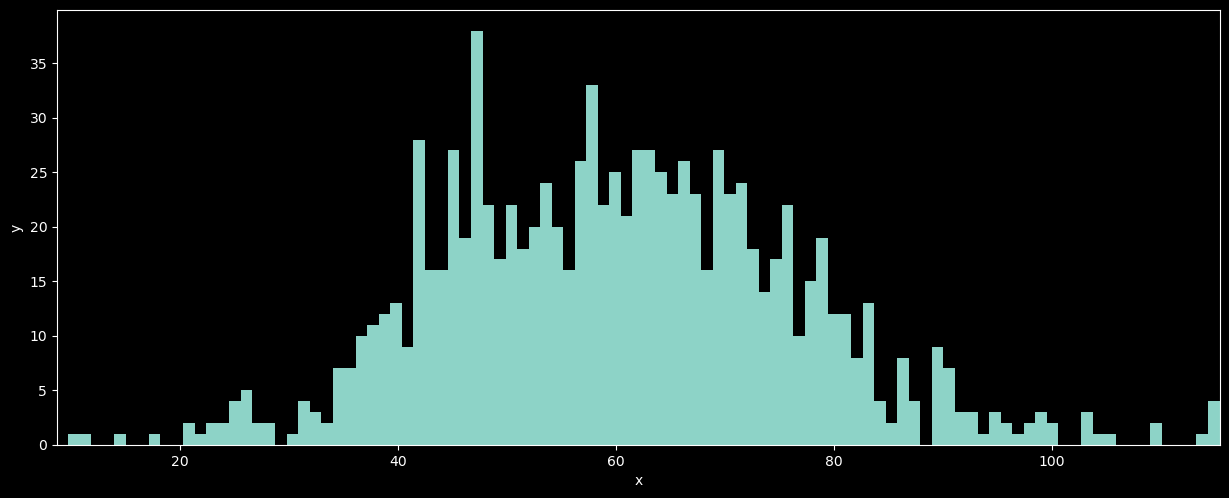

In [11]:
plt.style.use("dark_background")
plt.figure(figsize=(15,15))
plt.hist(masking_ratio_values,bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(min(masking_ratio_values)-1, max(masking_ratio_values))
# plt.ylim(0, 1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [13]:
import math

mean = np.mean(masking_ratio_values)
std = np.std(masking_ratio_values)
left_cutoff = math.ceil(mean - 2*std)
right_cutoff = math.ceil(mean + 2*std)

print(left_cutoff,right_cutoff)

28 92


In [13]:
indices = []
for i in range(len(YTRAIN)):    
    if masking_ratio_values[i]<=40 or masking_ratio_values[i]>=80:
        indices.append(i)
        
YTRAIN = np.delete(YTRAIN, indices, axis = 0)
XTRAIN = np.delete(XTRAIN, indices, axis = 0)

In [12]:
PATCH_XTRAIN = []
PATCH_YTRAIN = []

for img in XTRAIN:
    PATCH_XTRAIN.extend(make_patch(img))
    
print("PATCH_XTRAIN DONE")

for mask in YTRAIN:
    PATCH_YTRAIN.extend(make_patch(mask))
    
print("PATCH_YTRAIN DONE")

PATCH_XTRAIN DONE
PATCH_YTRAIN DONE


In [13]:
PATCH_XTRAIN = np.array(PATCH_XTRAIN).reshape(-1,256,256,1)
PATCH_YTRAIN = np.array(PATCH_YTRAIN).reshape(-1,256,256,1)
print(PATCH_XTRAIN.shape)
print(PATCH_YTRAIN.shape)

(3224, 256, 256, 1)
(3224, 256, 256, 1)


In [14]:
XTRAIN,YTRAIN = sklearn.utils.shuffle(XTRAIN,YTRAIN)

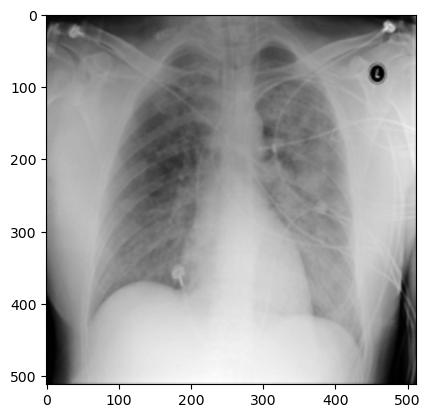

In [15]:
plt.imshow(XTRAIN[1],cmap = 'gray')

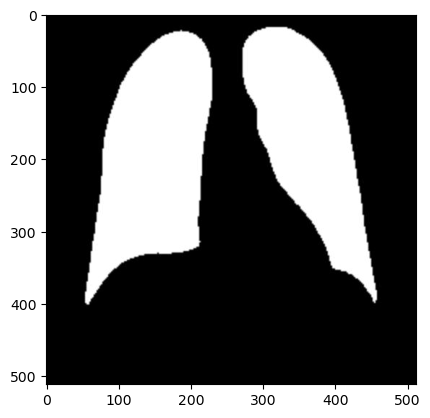

In [16]:
plt.imshow(YTRAIN[1],cmap = 'gray')

In [11]:
VAL_XTRAIN = []
VAL_YTRAIN = []

TRAIN_PARENT_PATH = os.path.join(DATA_DIR,SET[2])
VAL_TRAIN_IMG_PATH = TRAIN_PARENT_PATH + 'image/'
VAL_TRAIN_MASK_PATH = TRAIN_PARENT_PATH + 'mask/'

for img in os.listdir(VAL_TRAIN_IMG_PATH):
    IMG_PATH = os.path.join(VAL_TRAIN_IMG_PATH,img)
    img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
    img_array.resize(256,256,1)
    VAL_XTRAIN.append(img_array)
        
for mask in os.listdir(VAL_TRAIN_MASK_PATH):
    MASK_PATH = os.path.join(VAL_TRAIN_MASK_PATH,mask)
    img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
    img_array.resize(256,256,1)
    VAL_YTRAIN.append(img_array)

In [12]:
XTRAIN = np.array(XTRAIN).reshape(-1,256,256,1)
YTRAIN = np.array(YTRAIN).reshape(-1,256,256,1)

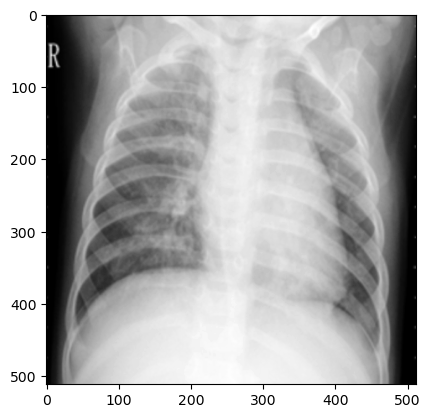

In [13]:
plt.imshow(VAL_XTRAIN[0],cmap = 'gray')

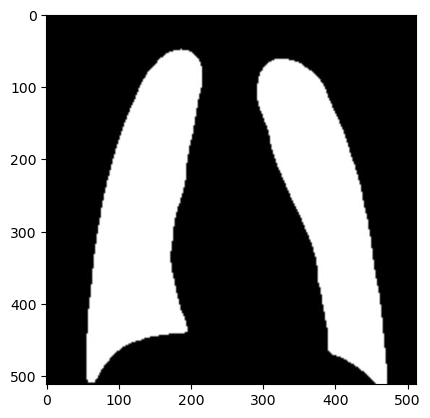

In [14]:
plt.imshow(VAL_YTRAIN[0],cmap = 'gray')

In [20]:
XTEST = []
YTEST = []

TEST_PARENT_PATH = os.path.join(DATA_DIR,SET[1])
TEST_IMG_PATH = TEST_PARENT_PATH + 'image/'
TEST_MASK_PATH = TEST_PARENT_PATH + 'mask/'
count = 0

for img in os.listdir(TEST_IMG_PATH):
    if count<100:
        IMG_PATH = os.path.join(TEST_IMG_PATH,img)
        img_array = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        XTEST.append(img_array)
        count += 1
print("XTEST DONE")
count = 0

for mask in os.listdir(TEST_MASK_PATH):
    if count<100:
        MASK_PATH = os.path.join(TEST_MASK_PATH,mask)
        img_array = cv2.imread(MASK_PATH,cv2.IMREAD_GRAYSCALE)
        img_array.resize(512,512,1)
        YTEST.append(img_array)
        count += 1
        
print("YTEST done")

XTEST DONE
YTEST done


In [21]:
XTEST = np.array(XTEST).reshape(-1,512,512,1)/511
YTEST = np.array(YTEST).reshape(-1,512,512,1).astype('float32')
print("DONE")

DONE


In [22]:
masking_ratio_values = np.zeros(len(YTEST))
for i in range(len(YTEST)):
    masking_ratio_values[i] = masking_ratio(YTEST[i],[512,512])

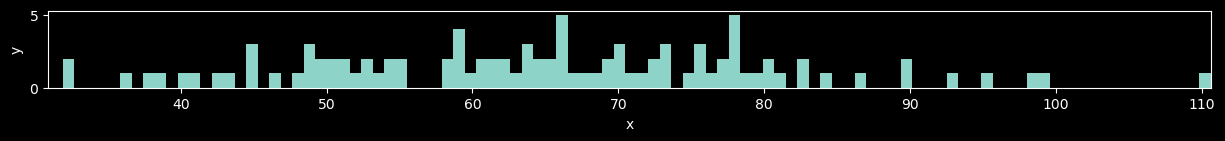

In [25]:
plt.style.use("dark_background")
plt.figure(figsize=(15,15))
plt.hist(masking_ratio_values,bins=100)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(min(masking_ratio_values)-1, max(masking_ratio_values))
# plt.ylim(0, 1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [17]:
XTRAIN.shape

(636, 512, 512, 1)

In [13]:
PATCH_XTEST = []
PATCH_YTEST = []

for img in XTEST:
    PATCH_XTEST.extend(make_patch(img))
    
print("PATCH_XTEST DONE")

for mask in YTEST:
    PATCH_YTEST.extend(make_patch(mask))
    
print("PATCH_YTEST DONE")

PATCH_XTEST DONE
PATCH_YTEST DONE


In [14]:
PATCH_XTEST = np.array(PATCH_XTEST).reshape(-1,256,256,1)
PATCH_YTEST = np.array(PATCH_YTEST).reshape(-1,256,256,1)
print(PATCH_XTEST.shape)
print(PATCH_YTEST.shape)

(400, 256, 256, 1)
(400, 256, 256, 1)


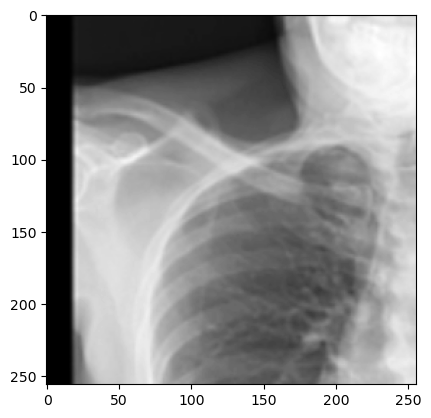

In [30]:
plt.imshow(PATCH_XTEST[0],cmap = 'gray')

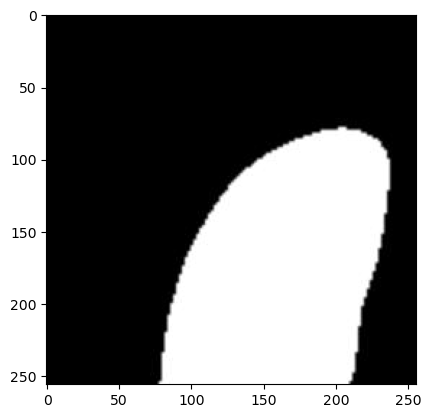

In [31]:
plt.imshow(PATCH_YTEST[0],cmap = 'gray')

In [20]:
from keras import backend as K

# def jacard_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def Jaccard_coef(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def Jaccard_loss(y_true,y_pred):
    return -Jaccard_coef(y_true,y_pred)

def Jaccard_distance(y_true, y_pred, smooth=100):
    jac = Jaccard_coef(y_true, y_pred)
    return (1 - jac) * smooth

In [23]:
model = multi_unet_model(IMG_SIZE = [512,512], IMG_CHANNELS = 1, N_CLASSES = 1 )
model.compile(
        optimizer = 'adam',
        loss = [Jaccard_distance],
        metrics = ['accuracy',Jaccard_coef]
    )
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 512, 512, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 512, 512, 64  0           ['conv2d_38[0][0]']              
                                )                                                           

In [25]:
history = model.fit(XTRAIN,YTRAIN,batch_size = 64,validation_split = 0.33 ,epochs = 50)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [19]:
yhat = model.predict(PATCH_XTRAIN[-5:,:,:,:])

1/1 [==============================] - 0s 417ms/step


In [22]:
yhat[0]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)